In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import * 
from IPython.display import Image, display_svg, SVG
import numpy as np
 
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8



In [2]:
path = Path('../../..')
Path.BASE_PATH = path


In [3]:
to = load_pickle(path/'models/splits.pkl')

In [4]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
valid_xs.shape, valid_y.shape

((17832, 178), (17832,))

## Function for metric (RMSE)

In [31]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()),6)
def m_rmse(m,xs,y): return r_mse(m.predict(xs),y)

## Train model without cleaning data

In [32]:
def rf(xs, y, n_estimators=60,
        max_features = 0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=1, n_estimators=n_estimators,
         max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs,y)

In [7]:
m = rf(xs,y)

## Results

In [8]:
print(f'root mean square error for - training set: {m_rmse(m,xs,y)}, and validation set: {m_rmse(m,valid_xs,valid_y)}')

root mean square error for - training set: 1.206335, and validation set: 1.429673


In [9]:
print(f'out-of-bag error: {r_mse(m.oob_prediction_,y)}')

out-of-bag error: 1.578355


## Find feature importance

In [10]:
def rf_feat_importance(m,df_2016_T07):
    return pd.DataFrame({'cols':df_2016_T07.columns, 'imp':m.feature_importances_}
                        ).sort_values('imp', ascending=False)

In [11]:
fi = rf_feat_importance(m,xs)
fi[:10]

,cols,imp
98,Gen_Phase3_Temp_Avg,0.448644
97,Gen_Phase2_Temp_Avg,0.156967
170,Gen_Bear2_Temp_Avg,0.122017
96,Gen_Phase1_Temp_Avg,0.084487
150,Grd_Busbar_Temp_Avg,0.043971
134,Cont_VCP_ChokcoilTemp_Avg,0.037543
100,Gear_Oil_Temp_Avg,0.027906
122,HVTrafo_Phase2_Temp_Avg,0.027644
127,Cont_VCP_Temp_Avg,0.010270
128,Gen_SlipRing_Temp_Avg,0.009757


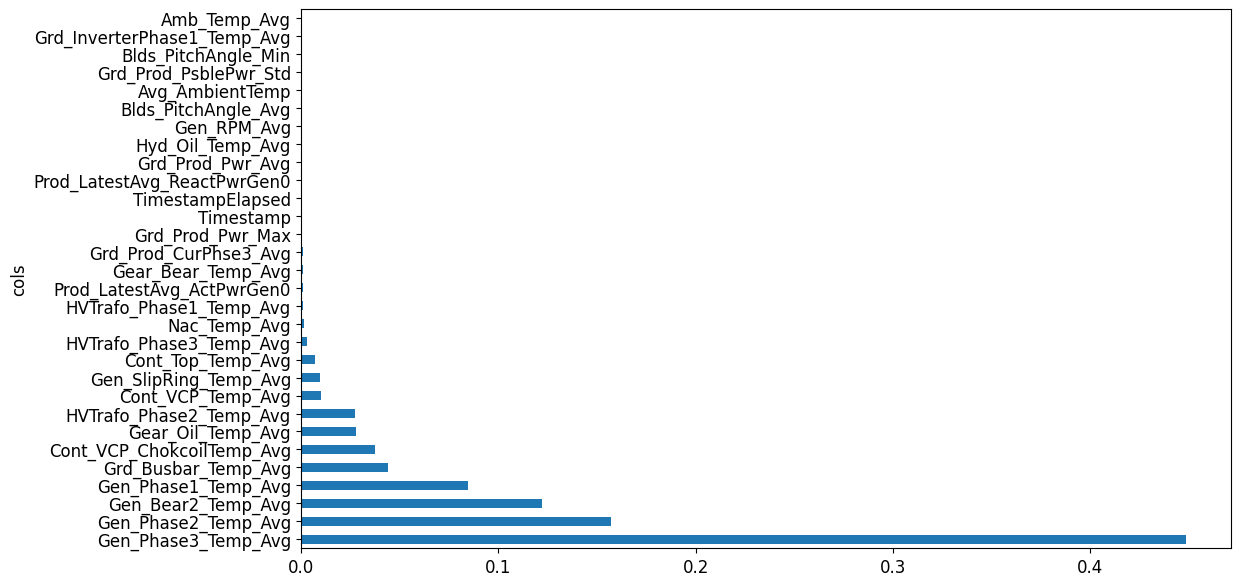

In [12]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

## Remove unimportant features

In [13]:
to_keep = fi[fi.imp>0.002].cols
len(to_keep)

12

In [14]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [15]:
m = rf(xs_imp, y)

## Results

In [16]:
print(f'root mean square error for - test set: {m_rmse(m,xs_imp,y)}, and validation set: {m_rmse(m,valid_xs_imp,valid_y)}')

root mean square error for - test set: 1.460191, and validation set: 1.433904


In [17]:
print(f'out-of-bag error: {r_mse(m.oob_prediction_,y)}')

out-of-bag error: 1.77648


## Remove redundant features

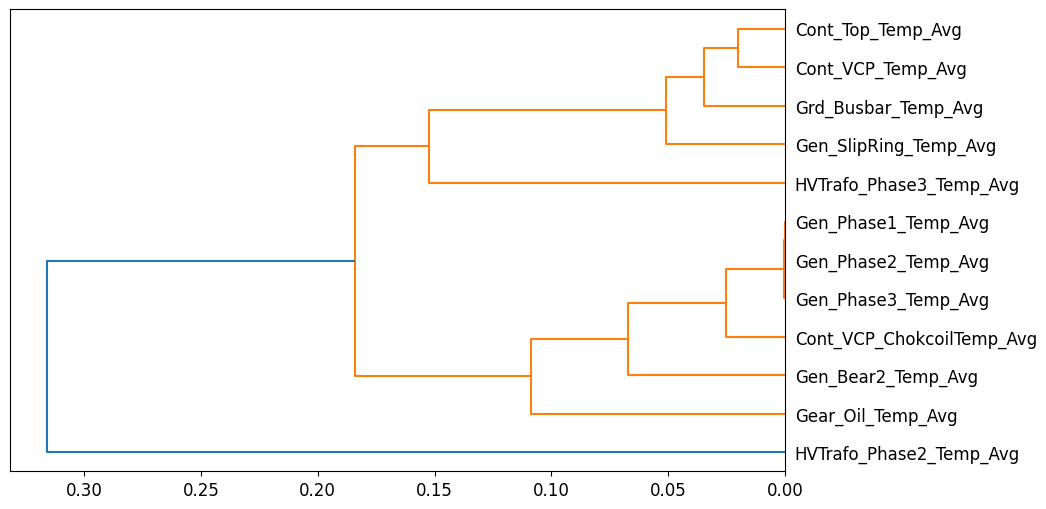

In [18]:
cluster_columns(xs_imp)

In [19]:
def get_oob(df_2016_T07):
    m = RandomForestRegressor(n_estimators=60, min_samples_leaf=15,
        max_features=0.5, n_jobs=1, oob_score=True)
    m.fit(df_2016_T07,y)
    return m.oob_score_

In [20]:
{c:get_oob(xs_imp.drop(c,axis=1)) for c in (
    'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Cont_Top_Temp_Avg','Cont_VCP_Temp_Avg'
)}

{'Gen_Phase1_Temp_Avg': 0.9828921435395819,
 'Gen_Phase2_Temp_Avg': 0.983089261026111,
 'Gen_Phase3_Temp_Avg': 0.9825717998011803,
 'Cont_Top_Temp_Avg': 0.9822409726513021,
 'Cont_VCP_Temp_Avg': 0.982561052776728}

In [21]:
to_drop = ['Gen_Phase2_Temp_Avg','Gen_Phase3_Temp_Avg','Cont_VCP_Temp_Avg']
get_oob(xs_imp.drop(to_drop,axis=1))

0.9825262686367956

In [22]:
xs_final = xs_imp.drop(to_drop,axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [23]:


m = rf(xs_final,y)


In [24]:
save_pickle(path/'models/final_model.pkl', m)

In [25]:
save_pickle(path/'models/final_data_train.pkl',xs_final)
save_pickle(path/'models/final_data_val.pkl',valid_xs_final)

## Final Results

In [33]:
print(f'root mean square error for - test set: {m_rmse(m,xs_final,y)}, and validation set: {m_rmse(m,valid_xs_final,valid_y)}')

root mean square error for - test set: 1.466929, and validation set: 1.455647


In [27]:
print(f'out-of-bag error: {r_mse(m.oob_prediction_,y)}')

out-of-bag error: 1.806868


In [29]:
from sklearn.metrics import root_mean_squared_error
print(f'root mean square error for - test set: {root_mean_squared_error(m.predict(xs_final),y)}')

root mean square error for - test set: 1.466929000996432


In [34]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m,df_dom[:6])

,cols,imp
8,HVTrafo_Phase3_Temp_Avg,0.354584
5,HVTrafo_Phase2_Temp_Avg,0.216914
3,Cont_VCP_ChokcoilTemp_Avg,0.083872
6,Gen_SlipRing_Temp_Avg,0.069527
1,Gen_Phase1_Temp_Avg,0.060677
0,Gen_Bear2_Temp_Avg,0.058895
2,Grd_Busbar_Temp_Avg,0.053365
7,Cont_Top_Temp_Avg,0.052866
4,Gear_Oil_Temp_Avg,0.049300


In [44]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('HVTrafo_Phase3_Temp_Avg','HVTrafo_Phase2_Temp_Avg','Cont_VCP_ChokcoilTemp_Avg'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 1.481325
HVTrafo_Phase3_Temp_Avg 1.474287
HVTrafo_Phase2_Temp_Avg 1.553594
Cont_VCP_ChokcoilTemp_Avg 1.471083


In [46]:
time_vars = ['HVTrafo_Phase3_Temp_Avg']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

1.462141

Removing this variable has slightly improved the model's accuracy; but more importantly, it should make it more resilient over time, and easier to maintain and understand.